In [1]:
import cv2
from PIL import Image
import os
import numpy as np
import matplotlib.patches as patches

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset
from tqdm import tqdm

from matplotlib import pyplot as plt
import pickle
from torchvision.ops import box_iou

In [2]:
# Hyperparameters

SEED = 41


NUM_EPOCHS = 5

LR = 0.005
LR_MOMENTUM=0.9
LR_DECAY_RATE=0.0005

LR_SCHED_STEP_SIZE = 0.1
LR_SCHED_GAMMA = 0.1

BATCH_SIZE = 8

NUM_TEST_IMAGES = 5
NMS_THRESH = 0.01

img_sz=1024


saveName="end_prod1"

In [3]:
def parse_labels(file_path,yolo=False):
    labels = []
    with open(file_path, 'r') as file:
        if(yolo):
            splitted=file_path.split("/")
            imagename=splitted[3][:-4]+".png"
            
            image = Image.open(os.path.join(splitted[0],splitted[1],"images",imagename))
        for line in file:
            parts = line.strip().split()
            x = float(parts[1])
            y = float(parts[2])
            x_width = float(parts[3])
            y_width = float(parts[4])
            if(yolo):
                x,y,x_width,y_width=x*image.width,y*image.height,x_width*image.width,y_width*image.height
                x1,y1,x2,y2=x-x_width,y-y_width,x+x_width,y+y_width
                labels.append((1, x1 ,y1 ,x2, y2))
            else:
                labels.append((1, x,y,x_width,y_width))

        if(len(labels)==0):
            labels.append((0, 0, 0, -1, -1))

    return np.array(labels)

def plot_bounding_boxes(image_path, label_path):
    # Load the image
    image = Image.open(image_path)

    # Load COCO format labels
    coco_labels = parse_labels(label_path)

    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Add bounding boxes to the image
    for annotation in coco_labels:
        bbox = annotation
        # COCO format: [x, y, width, height]
        class_, x, y, width, height = bbox
        x, y, width, height = x*image.width, y*image.height, width*image.width, height*image.height
        rect = patches.Rectangle((x-width, y-height), width*2, height*2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Display the image with bounding boxes
    plt.show()

def resize_and_pad_image_with_bboxes(image, bboxes, target_height, target_width):
    """
    Resize and pad an image and adjust bounding boxes to the target dimensions.

    Args:
    - image (numpy.ndarray): Input image as a numpy array (H, W, C).
    - bboxes (list of tuples): List of bounding boxes [(xmin, ymin, xmax, ymax), ...].
    - target_height (int): Desired height of the output image.
    - target_width (int): Desired width of the output image.

    Returns:
    - numpy.ndarray: Resized and padded image.
    - list of tuples: Adjusted bounding boxes.
    """
    # Convert numpy array to PIL Image for resizing
    pil_image = Image.fromarray(image)

    # Calculate the aspect ratio of the image and the target dimensions
    original_width, original_height = pil_image.size
    if(bboxes[0][2]==-1):
        bboxes=np.array([[0,0,original_width,original_height]])
    aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height

    # Determine the new size of the image while maintaining the aspect ratio
    if aspect_ratio > target_aspect_ratio:
        # Image is wider than the target aspect ratio
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        # Image is taller than or equal to the target aspect ratio
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Resize the image
    resized_image = pil_image.resize((new_width, new_height))
    
    # Convert back to numpy array
    resized_image_np = np.array(resized_image)

    # Calculate scale factors for bounding boxes
    x_scale = new_width / original_width
    y_scale = new_height / original_height

    # Resize bounding boxes
    resized_bboxes = [(int(xmin * x_scale), int(ymin * y_scale), int(xmax * x_scale), int(ymax * y_scale)) for xmin, ymin, xmax, ymax in bboxes]

    # Calculate padding to achieve the target dimensions
    pad_height = target_height - new_height
    pad_width = target_width - new_width
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    # Pad the image
    padded_image = np.pad(resized_image_np,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode='constant',
        constant_values=255)

    # Adjust bounding boxes for padding
    padded_bboxes = [(xmin + pad_left, ymin + pad_top, xmax + pad_left, ymax + pad_top) for xmin, ymin, xmax, ymax in resized_bboxes]
    return padded_image, padded_bboxes

In [4]:
import time

class MammogramDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        # self.images=[cv2.imread(dir, cv2.IMREAD_GRAYSCALE) for dir in image_paths]
        self.labels = labels
        self.targets = []
        for i in range(len(image_paths)):
            self.targets.append(resize_and_pad_image_with_bboxes(cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE),
                                                                 labels[i][:,1:],img_sz,img_sz))


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        # start = time.time()
        # img_path = self.image_paths[idx]

        # start2 = time.time()
        # image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image,cord = self.targets[idx]
        # end2 = time.time()
        label = self.labels[idx]
        
        # cord=label[:,1:]
        # image, cord=resize_and_pad_image_with_bboxes(image,cord,img_sz,img_sz)
        # print(end2 - start2)
        if(len(label)>0 and label[0][0]!=0):
            classOf=label[:,0]
            image = torch.as_tensor(np.expand_dims(image/255,0))
            classOf=torch.as_tensor(classOf,dtype=torch.int64)
            cord=torch.as_tensor(cord,dtype=torch.float32)
        else:
            image = torch.as_tensor(np.expand_dims(image/255,0))
            classOf=torch.as_tensor([0],dtype=torch.int64)
            cord=torch.as_tensor(cord,dtype=torch.float32)

        label={
            "labels": classOf,
            "boxes": cord
        }
        end = time.time()
        # print(end - start, end2 - start2)
        return image, label

def collate_fn(batch):
  return tuple(zip(*batch))

take_directory_i="prodAugmented/train/images/"
take_directory_l="prodAugmented/train/labels/"

#since val is same it is getting the data from the pascal_voc dataset
take_directory_vi="prodData/test/images/"
take_directory_vl="prodRcnnLabels/test/labels/"

image_paths=[take_directory_i+dir for dir in os.listdir(take_directory_i)]
labels=[np.array(parse_labels(take_directory_l+file,yolo=True)) for file in os.listdir(take_directory_l)]


image_paths_val=[take_directory_vi+dir for dir in os.listdir(take_directory_vi)]
labels_val=[np.array(parse_labels(take_directory_vl+file)) for file in os.listdir(take_directory_vl)]

print(f"t/i {len(image_paths)} t/l {len(labels)} v/i {len(image_paths_val)} v/l {len(labels_val)}")

t/i 7879 t/l 7879 v/i 1499 v/l 1499


In [5]:
# dataset = MammogramDataset(image_paths_val, labels_val)    
# data_loader = torch.utils.data.DataLoader(
#   dataset, batch_size=8, shuffle=True,collate_fn=collate_fn)
# for i, (im,l) in enumerate(data_loader):
#   # if(l["labels"].shape)
#   for lab in l:
#     print(lab["boxes"])
#     # if(len(lab["labels"])==0):
#     #   print(lab, i)

#   break

In [6]:

current_dir = os.getcwd()+"/RCNN/"

namer = saveName
output_dir_name = "output-" + namer

#TODO make sure to save different folders to avoid overlap

OUTPUT_DIR = os.path.join(current_dir, output_dir_name)
os.makedirs(OUTPUT_DIR, exist_ok=True)  

In [7]:
classes = ["Background", "cancer"]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device}")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = len(classes)  # 3 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

num_epochs = NUM_EPOCHS

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR, momentum=LR_MOMENTUM, weight_decay=LR_DECAY_RATE)
# optimizer = torch.optim.Adam(params)

Using cuda


In [8]:

# create a train- and validation-dataset with our vehicleDataset
# split the dataset in train and test set
dataset = MammogramDataset(image_paths, labels)    
dataset_val = MammogramDataset(image_paths_val, labels_val)

# create a learning rate scheduler
# TODO: step size to be tuned !
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, \
                                                step_size=LR_SCHED_STEP_SIZE, \
                                                gamma=LR_SCHED_GAMMA)
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn)

data_loader_val = torch.utils.data.DataLoader(
  dataset_val, batch_size=1, shuffle=True,collate_fn=collate_fn)

In [9]:
'''
Function to train the model over one epoch.
'''
def train_one_epoch(model, optimizer, data_loader, device):
  model.train()
  train_loss_list = []

  tqdm_bar = tqdm(data_loader, total=len(data_loader))
  for idx, data in enumerate(tqdm_bar):
    optimizer.zero_grad()
    images, labels = data
    # print(labels)
    
    # start = time.time()
    images = list(image.to(device).float() for image in images)
    targets=list({
          "labels":label["labels"].to(device),
          "boxes" :label["boxes"].to(device).float()
          } for label in labels)    

    losses = model(images, targets)
    # end = time.time()
    # print("gpu_transfer",end - start)

    loss = sum(loss for loss in losses.values())
    train_loss_list.append(loss.detach().cpu().numpy())

    # start = time.time()
    loss.backward()
    # end = time.time()
    # print("loss",end - start)
    
    # start = time.time()
    optimizer.step()
    # end = time.time()
    # print("optimizer",end - start)
    
    # start = time.time()
    tqdm_bar.set_description(desc=f"Training Loss: {loss:.3f}")
    # end = time.time()
    # print("tdqm",end - start)s
    

  return train_loss_list

def evaluate(model, data_loader_val, device, iou_threshold=0.5):
    val_loss_list = []
    TP, FP, FN = 0, 0, 0

    tqdm_bar = tqdm(data_loader_val, total=len(data_loader_val))
    for i, data in enumerate(tqdm_bar):
        images, labels = data

        images = list(image.to(device).float() for image in images)
        targets = [{
            "labels": label["labels"].to(device),
            "boxes": label["boxes"].to(device).float()
        } for label in labels]
        
        with torch.no_grad():
            model.eval()
            outputs = model(images)

            # Manually calculate the losses using the same criterion used during training
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        loss_val = losses.item()
        val_loss_list.append(loss_val)
        
        # Update the progress bar with the loss
        tqdm_bar.set_description(desc=f"Validation Loss: {losses:.4f}")

        # Calculate TP, FP, FN for F1 score
        for target, output in zip(targets, outputs):
            true_boxes = target["boxes"]
            pred_boxes = output["boxes"]
            pred_scores = output["scores"]
            pred_labels = output["labels"]

            # Filter predictions based on a score threshold
            score_threshold = 0.5
            keep = pred_scores >= score_threshold
            pred_boxes = pred_boxes[keep]
            pred_labels = pred_labels[keep]

            if len(pred_boxes) == 0 and len(target["labels"])==1 and target["labels"].item()==0:
                continue
            elif len(pred_boxes) == 0:
                FN += len(true_boxes)
                continue

            ious = box_iou(pred_boxes, true_boxes)
            iou_max, iou_idx = ious.max(dim=1)

            # Calculate TP, FP, FN
            for iou, idx in zip(iou_max, iou_idx):
                if iou >= iou_threshold:
                    TP += 1
                else:
                    FP += 1

            FN += len(true_boxes) - ious.max(dim=0)[0].ge(iou_threshold).sum().item()
        

    # Calculate precision, recall, and F1 score
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

    return val_loss_list, f1_score

def plot_loss(train_loss, valid_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    train_ax.plot(train_loss, color='blue')
    train_ax.set_xlabel('Iteration')
    train_ax.set_ylabel('Training Loss')

    valid_ax.plot(valid_loss, color='red')
    valid_ax.set_xlabel('Iteration')
    valid_ax.set_ylabel('Validation loss')

    figure_1.savefig(f"{OUTPUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUTPUT_DIR}/valid_loss.png")

In [10]:
# find latest saved chcekpoint
checkpoint_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.pth')]
if checkpoint_files:
    # Last ckpt file
    checkpoint_files.sort()
    latest_checkpoint = os.path.join(OUTPUT_DIR, checkpoint_files[-1])

    # Load the ckpt
    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss_dict = checkpoint['loss_dict']
else:
    start_epoch = 0
    loss_dict = {'train_loss': [], 'valid_loss': [], "f1_score":[]}

----------Epoch 1----------


Validation Loss: 0.0064: 100%|██████████| 1499/1499 [03:28<00:00,  7.19it/s]


Precision: 0.4923, Recall: 0.4700, F1 Score: 0.4809
----------Epoch 2----------


Validation Loss: 0.0027: 100%|██████████| 1499/1499 [03:35<00:00,  6.96it/s]


Precision: 0.5112, Recall: 0.5217, F1 Score: 0.5164
----------Epoch 3----------


Validation Loss: 0.0044: 100%|██████████| 1499/1499 [03:31<00:00,  7.09it/s]


Precision: 0.5330, Recall: 0.5380, F1 Score: 0.5355
----------Epoch 4----------


Validation Loss: 0.4143: 100%|██████████| 1499/1499 [03:19<00:00,  7.50it/s]


Precision: 0.4499, Recall: 0.5328, F1 Score: 0.4879
----------Epoch 5----------


Training Loss: 0.199:   3%|▎         | 30/985 [01:12<38:23,  2.41s/it]


KeyboardInterrupt: 

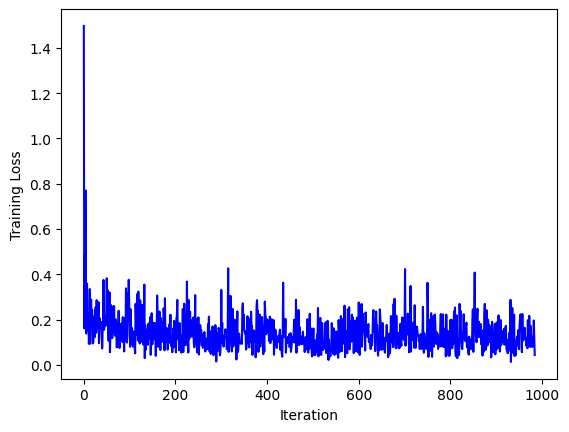

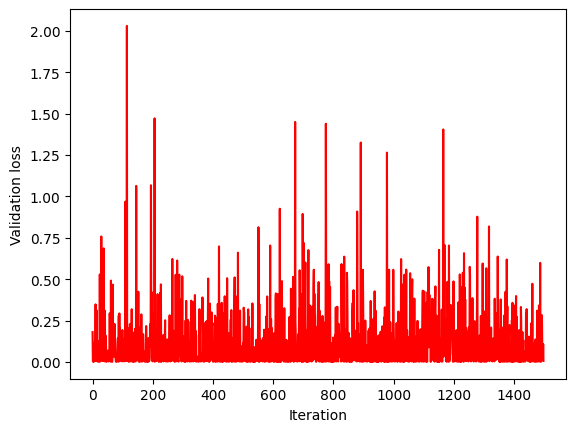

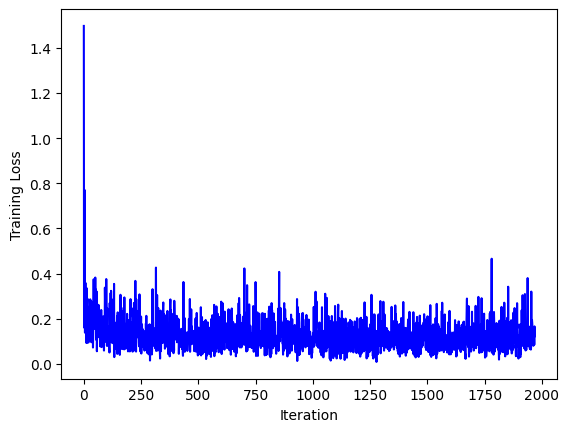

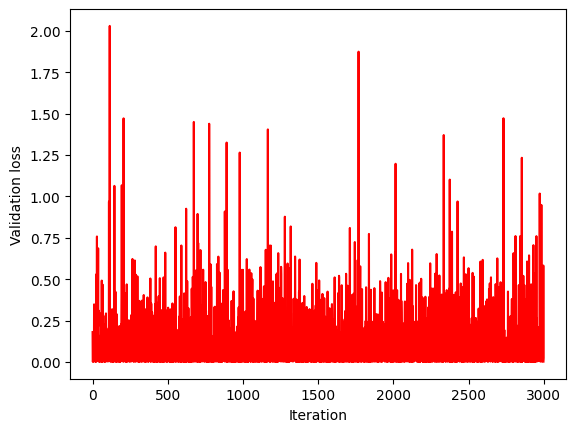

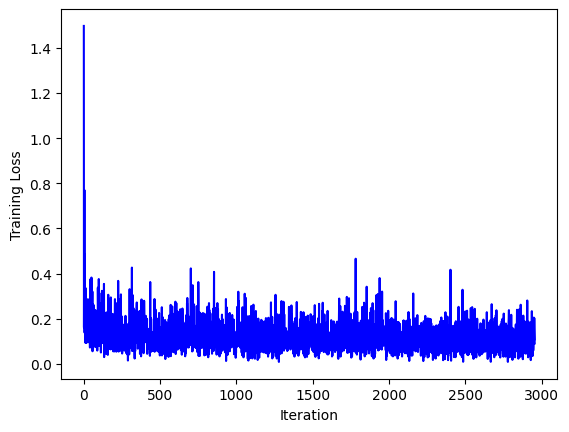

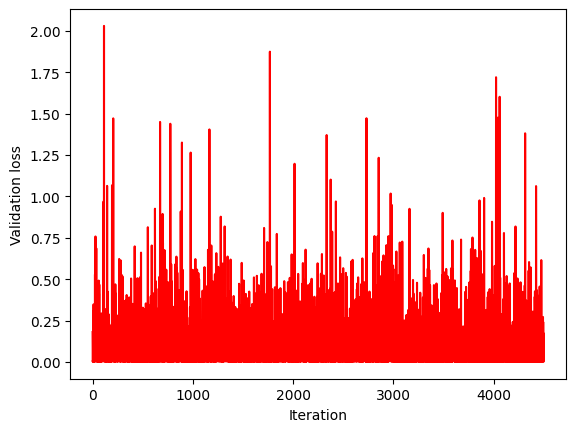

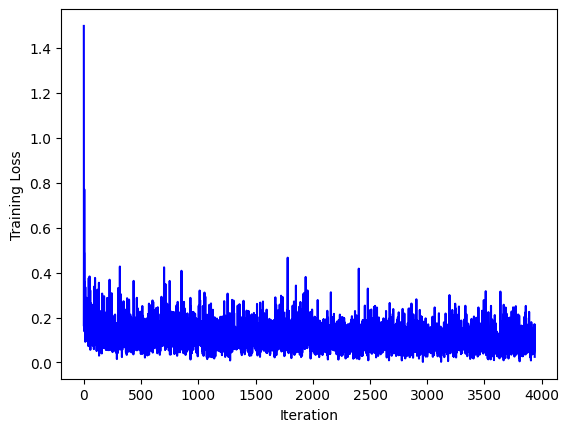

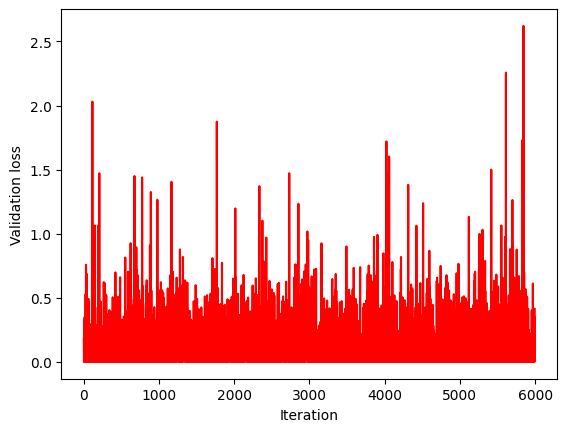

In [11]:
for epoch in range(start_epoch, num_epochs):
  print("----------Epoch {}----------".format(epoch+1))

  train_loss_list = train_one_epoch(model, optimizer, data_loader, device)

  
  loss_dict['train_loss'].extend(train_loss_list)

  lr_scheduler.step()  # Run evaluation
  valid_loss_list, f1Score = evaluate(model, data_loader_val, device)

  #TODO add f1 scaled weight save
  loss_dict['valid_loss'].extend(valid_loss_list)
  loss_dict['f1_score'].append(f1Score)

  # Svae the model ckpt after every epoch
  ckpt_file_name = f"{OUTPUT_DIR}/epoch_{epoch+1}_model.pth"
  torch.save({
    'epoch': epoch+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_dict': loss_dict
  }, ckpt_file_name)
  
  if(max(loss_dict['f1_score'])== f1Score):
    ckpt_file_name = f"{OUTPUT_DIR}/best_model.pth"
    torch.save({
      'epoch': epoch+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss_dict': loss_dict
    }, ckpt_file_name)

  # NOTE: The losses are accumulated over all iterations
  plot_loss(loss_dict['train_loss'], loss_dict['valid_loss'])

# Store the losses after the training in a pickle
with open(f"{OUTPUT_DIR}/loss_dict.pkl", "wb") as file:
    pickle.dump(loss_dict, file)

print("Training Finished !")